# Primary Health Care Accessibility in Ontario

## Objectives 

The main objective of this project is to understand the accessibility of health care which focusing primarily on family medicine, and determine the possible gaps due to inaccessibility of clinics in Ontario, Canada. Healthcare crisis is a known problem in the province, and in Canada for recent years;this has even highligthed in main political campaign  promises during elections even in politically due to growing concern on the access to basic healthcare. Therefore, it is important to understand where the problem is originated. 

The dataset which we are using in this section downloaded from Ontario Open data platform ( *https://data.ontario.ca/dataset/family-health-team-fht-locations*) and Statistics Canada (*https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001901*)

In [4]:
#importing all necessary libraries for data analysis and visualization

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas
import plotly.express as px

### 1. Data Inspection and Cleaning 

We have two separate datasets: 
- Family Health Team locations by Ontario Health Ministry
- Population, Dwellings by Forward Sortation Areas from Census 2021 (Statistics Canada)

The goal of this section to understand both datasets, and scrape only the necessary attributes to investigate the accessibility of healthcare providers that are only considered as family medicine focused clinics, and their corresponding location and population combined.

In [6]:
#source data downloaded from:https://data.ontario.ca/dataset/family-health-team-fht-locations

# data text file loaded in pandas and inspected to identify significant attribute for our analysis 
url = 'Ministry_of_Health_Service_Provider_Locations.csv'
location_data = pd.read_csv(url, sep = ',',  encoding='latin-1')
location_data.info()
location_data.drop(['FRENCH_NAME', 'FRENCH_NAME_ALT', 'ENGLISH_NAME_ALT'], axis = 1)
location_data['SERVICE_TYPE'].unique()

#Service Type re-cateegorized to identify group of Primary Care Provider services:
location_data['NEW_SERVICE_TYPE'] = location_data['SERVICE_TYPE']
location_data.loc[location_data['SERVICE_TYPE'].str.contains('Family Health Team|Nurse Practitioner-Led Clinic|Indigenous Primary Health Care Organization|Nursing Station'), 'NEW_SERVICE_TYPE'] = 'Primary Care Provider'
location_data['NEW_SERVICE_TYPE'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ï»¿X                        11749 non-null  float64
 1   Y                           11749 non-null  float64
 2   OGF_ID                      11749 non-null  int64  
 3   MOH_SERVICE_PROVIDER_IDENT  11749 non-null  object 
 4   SERVICE_TYPE                11749 non-null  object 
 5   SERVICE_TYPE_DETAIL         9976 non-null   object 
 6   ENGLISH_NAME                11749 non-null  object 
 7   FRENCH_NAME                 88 non-null     object 
 8   ENGLISH_NAME_ALT            916 non-null    object 
 9   FRENCH_NAME_ALT             4 non-null      object 
 10  ADDRESS_LINE_1              11749 non-null  object 
 11  ADDRESS_LINE_2              2813 non-null   object 
 12  ADDRESS_DESCRIPTOR          2173 non-null   object 
 13  COMMUNITY                   117

array(['Licensed Lab and Specimen Collection Centre Locations',
       'Licenced Retirement Home', 'Pharmacy', 'Long-Term Care Home',
       'Community Support Services', 'Primary Care Provider',
       'Mental Health and Addiction Organization',
       'Integrated Community Health Services Centre',
       'HIV/AIDS and Hep C Programs', 'Seniors Active Living Centre',
       'Hospital', "Children's Treatment Centre", 'Midwifery Clinic',
       'Public Health Unit Office Locations', 'Community Health Centre'],
      dtype=object)

In [7]:
#source data : https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001901
census_data = pd.read_csv('population count per fsc.csv', sep = ',', skiprows = 11, skipfooter = 8, names = ['forward sortation area', 'population_2021', 'Total private dwelling_2021', 'private dwelling by usual resident_2021'], engine =  'python')
census_data.info()
location_data.info()
location_data = location_data.rename(columns = {'ï»¿X' :'X'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   forward sortation area                   1646 non-null   object
 1   population_2021                          1646 non-null   object
 2   Total private dwelling_2021              1646 non-null   object
 3   private dwelling by usual resident_2021  1646 non-null   object
dtypes: object(4)
memory usage: 51.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ï»¿X                        11749 non-null  float64
 1   Y                           11749 non-null  float64
 2   OGF_ID                      11749 non-null  int64  
 3   MOH_SERVICE_PROVIDER_IDENT  11749 non-nu

Mainly : primary care provider density: count/km2 for regional can be calculated 
* Q1. Rural areas vs highly populated cities, type of primary care provider services offered - Treemap/scatter plot answers this 
* Q2. primary care provider: km2/population identification to understand the accessibility by the population around the clinics
  * A. Is the primary care provider serving a population size that is an outlier from provincial standards measured by the distance from any other provider 
  * B. Is the primary care provider, nearest provider to a population centre which will be considered inaccessable; i.e. greater 30 min commute time especially for small towns perhaps in northern ontario 


## 2. Data Preparation

Now we understand the attributes from both datasets, and cleaned the data to reflect only the necessary ones; we can combined these dataset using forwads sortation area using postal codes listed for each clinic, therefore the population information can be associated directly with the clinics. 

In [10]:
#create FSC column and match the FSC values from population dataset to combined corresponding population that the clinics located in. 
location_data['FSC'] = location_data['POSTAL_CODE'].str[:3]
population_fsc = census_data.drop(['Total private dwelling_2021', 'private dwelling by usual resident_2021'], axis =1)
population_fsc.set_index('forward sortation area', inplace = True)
population_fsc_dict = population_fsc.to_dict()

location_data['matched_FSC'] = location_data['FSC'].apply(lambda x: population_fsc_dict['population_2021'].get(x))
location_data['population'] = location_data['matched_FSC'].str.split(',').str.join('')
location_data['population'] = pd.to_numeric(location_data['population'])

#removing columns that ae not significant to our analysis such as goverment/business identifier columns, and name specifier columns as our analysis focuses on Ontario, french name might not be necessary and has lots of missing information.
location_data = location_data.drop(['OGF_ID', 'MOH_SERVICE_PROVIDER_IDENT','FRENCH_NAME','FRENCH_NAME_ALT', 'ENGLISH_NAME_ALT', 'matched_FSC'], axis = 1)

#narrowing down our dataset to only cover the primary care providers which was defined in the data inspection and cleaning section
primary_care_provider = location_data.loc[(location_data['NEW_SERVICE_TYPE'] == 'Primary Care Provider')]


In [11]:
# Filtering data based on Forward Sortation Codes to understand statistical summary of the primary care providers based on the location
fsc_count_df =  primary_care_provider.groupby(['FSC']).agg({'SERVICE_TYPE': 'count'})
fsc_count_dic = fsc_count_df.to_dict()

#creating a new column to identify number of clinics in that specific population area
primary_care_provider.loc[:,'pop_count'] = primary_care_provider.loc[:, 'FSC'].apply(lambda x: fsc_count_dic['SERVICE_TYPE'].get(x))

# if FSC contains '0' in the second character, it is defined as that the area considered to be rural area vs if it is different than zero '0', it is defined as urban area according to the Canada Post designation of FSCs. 
primary_care_provider.loc[:,'population_density_per_are'] = primary_care_provider.loc[:,'FSC'].apply(lambda x: 'rural' if '0' in x else 'urban')


primary_care_provider.loc[:, 'pop_per_clinic'] = primary_care_provider['population']/primary_care_provider['pop_count']


/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_60507/1979022235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider.loc[:,'pop_count'] = primary_care_provider.loc[:, 'FSC'].apply(lambda x: fsc_count_dic['SERVICE_TYPE'].get(x))
/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_60507/1979022235.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider.loc[:,'population_density_per_are'] = primary_care_provider.loc[:,'FSC'].apply(lambda x: 'rural' if '

## 3. Data Visulization 
Since we have a clean dataset which focuses on specifically primary care provider offices located in Ontario, now we can look deeper into the spread of these offices per forward sortation area codes, communities, and population aggloremates. We understand that the data analyzed in this project does not captures all available clinics which are not considered as Family Health Teams by Ontario Health ministry. Therefore, our visualization will assume the accessibility covered by only these units listed in this dataset. 

In [13]:
from shapely.geometry import Point

primary_care_provider['coordinates'] =list(zip(primary_care_provider.X, primary_care_provider.Y))
primary_care_provider['coordinates'] = primary_care_provider['coordinates'].apply(Point)

gdf = geopandas.GeoDataFrame(primary_care_provider, geometry = 'coordinates')

/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_60507/3653125550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider['coordinates'] =list(zip(primary_care_provider.X, primary_care_provider.Y))
/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_60507/3653125550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider['coordinates'] = primary_care_provider['coordinates'].apply(Point)


Let's see first what are percentage of areas that does not contain any clinic in Ontario

In [15]:
# of area code that does not have any clinic:
area_no_clinic = (len(primary_care_provider['FSC'])/len (location_data ['FSC']))*100
print( 'Percentage of areas that does not contain primary care provider clinic', area_no_clinic, '%')

Percentage of areas that does not contain primary care provider clinic 2.0597497659375263 %


In [16]:
# grouping data to aggreagate statistical summaries 

grouped_df = primary_care_provider.groupby(['population_density_per_are','FSC'])
aggregated_pop_clinic = grouped_df[['pop_count', 'pop_per_clinic','population']].mean()
aggregated_pop_clinic.agg(['min', 'max', 'mean'])

,pop_count,pop_per_clinic,population
min,1.0000,3149.000000,3149.000000
max,10.0000,110956.000000,115850.000000
mean,1.5125,25680.937107,32244.232704


#### Early Discussion Point
As evidenced by the analysis above, we have aggregated the number of primary health centers and their associated population. Making a generalized assumption that clinics are situated in order to serve their local population within meaningful agglomeration areas, this would indicate that the average individual family health clinic is servicing 25,000+ Ontario residents.

It is worth the effort to attempt to visualize the distribution of populations and associated named municipalities to validate the assumption and look for correlation between population and the number of clinics co-located in a forward sortation area. 

An interesting point here is that we can use our engineered feature column for 'Urban' versus 'Rural' to distinguish between areas with very different population densities.

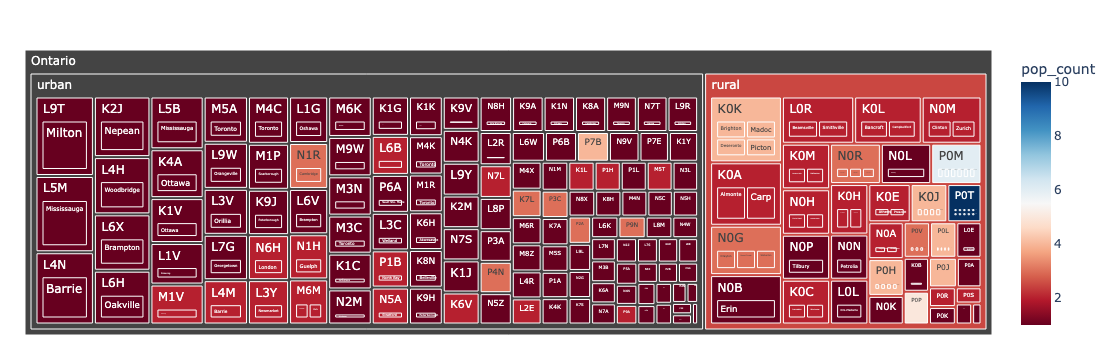

In [31]:
df = primary_care_provider
fig = px.treemap(df, path=[px.Constant("Ontario"), 'population_density_per_are','FSC', 'COMMUNITY'], 
                 values='pop_per_clinic', color = 'pop_count', color_continuous_scale = 'RdBu', hover_data = ['population','COMMUNITY'],
                 color_continuous_midpoint=np.average(df['pop_count'], weights=df['pop_per_clinic']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

#plt.savefig("Ontario_healthcare_access_treemaps.png")
fig.show()
fig.write_html("Health_care_access_treemap.html")

#### Observations

- There are many more urban areas with smaller population serviced by lower number of clinics, on the other hand, rural areas with similar size population has higher number of clinic despite their small populations perhaps the land area covered by the population can be the effect in this discrepancy. Unfortunately, we do not know the land area covered per each population area in this dataset, however this assumption most likely correct as forward sortation area code in rural zones contains more than one community area which covered by this dataset. 
- Based on the above observation, Ontario Health ministry recommendation to open a new clinic might be depended on the land area, number of communities covered by that area and it's population.
- It is safe to say that most urban areas averages one clinic per area plainly shows the lack of health care providers available in the province. Number of doctors for each clinic is unknown from this dataset, however the mean value of the population covered by clinic exceeds 20,000 people is extremely high; which might also explains decline in doctors who chooses to serve as a family doctor in recent years as this job would come with significant workload and would be challenged by work/life balance. 

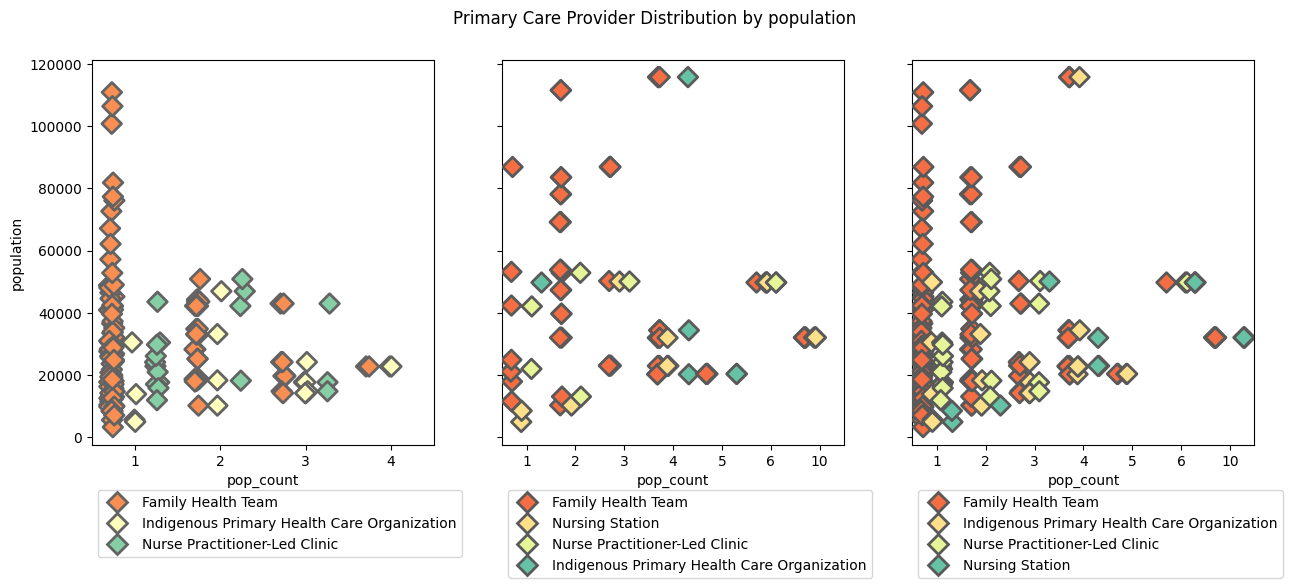

In [25]:
urban_df = df.loc[(df['population_density_per_are']) == 'urban']
rural_df = df.loc[(df['population_density_per_are']) == 'rural']

fig, axes =plt.subplots(1,3, figsize =(15, 5), sharey = True)
fig.suptitle('Primary Care Provider Distribution by population')

sns.stripplot(data=urban_df, x="pop_count", y="population", hue="SERVICE_TYPE", ax= axes[0], dodge = True, s=10, marker="D", linewidth=2, alpha=1, palette = 'Spectral')
sns.stripplot(data=rural_df,  x="pop_count", y="population", hue="SERVICE_TYPE", ax = axes[1], dodge = True, s=10, marker="D", linewidth=2, alpha=1, palette = 'Spectral')
sns.stripplot(data=df, x="pop_count", y="population", hue="SERVICE_TYPE", ax = axes[2], dodge = True, s=10, marker="D", linewidth=2, alpha=1, palette = 'Spectral')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.55, -0.1))
axes[1].legend(loc='upper center', bbox_to_anchor=(0.55, -0.1))
axes[2].legend(loc='upper center', bbox_to_anchor=(0.55, -0.1))

As we digged deeper into the primary care provider clinics available for each geogrophical location in Ontario, we see that there are different type of services which these each clinic identfied with.Here is the summary of the services types that are identified as primary care providers from the Ontario Minsitry of Health: 

- ***Family Health Team*** are identified as group of family doctors, nurse practioners, Mental health proffesionals and Ambulatory Services offered by a single clinic. Number of doctors and nurse practioneers are capable of serving larger group of patients, and this system enables to serve where access to the health care is more limited based on the definition of Family Health Team by the Ministry of Health in Ontario Goverment.
- ***Nurse Practitioner-Led Clinic*** provides support, education, and preventative care to patients as a primary care providers. This clinics can diagnose and treat common injuries and illness, and provide referrals for specialty services if needed.
- ***Nurse Stations*** provides primary care services in remote/rural areas
- ***Indigenous Primary Health Care Organization*** indigenous governed, culture-based, and Indigenous-informed organization that serves indigeous communities for their primary care services.

As can be seen from the figures above, the Family Health Team units covers larger populated areas and able to provide wider range of the need in urban population. However as we move forward towards less populated, rural areas, we see positive trend of number of clinics offered by nurse practioneers-led clinics, and nursing stations. The number of clinics are increasing with the increased number of population in the rural zone as this can be due to increase land area or number of communities covered by that specific geographical area. Another contributiing factor could be related to the number of primary care provider personnel available in 
